In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# test connetion
!ls '/content/gdrive/My Drive'

'Colab Notebooks'				   'to clean'
 Detection					    Untitled0.ipynb
 ML.ipynb					   'Untitled document (1).gdoc'
'Netlist generator'				   'Untitled document (2).gdoc'
 resume.pdf					   'Untitled document.gdoc'
 shared						   'Untitled folder'
'STATE OF KUWAIT CIVIL ID CARD_241130_224444.pdf'   Untitled.pdf


In [ ]:
!pip install ultralytics

In [ ]:
# test connetion
!ls '/content/gdrive/My Drive/Netlist generator'

'Current trained model'  'Model training'  'Program test'


Processing image: GND_test.jpg

image 1/1 /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Test images/GND_test.jpg: 448x640 6 Resistors, 2 Capacitors, 1 Transistor_MOSFET, 1 Voltage_src, 3 GNDs, 1073.3ms
Speed: 3.4ms preprocess, 1073.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


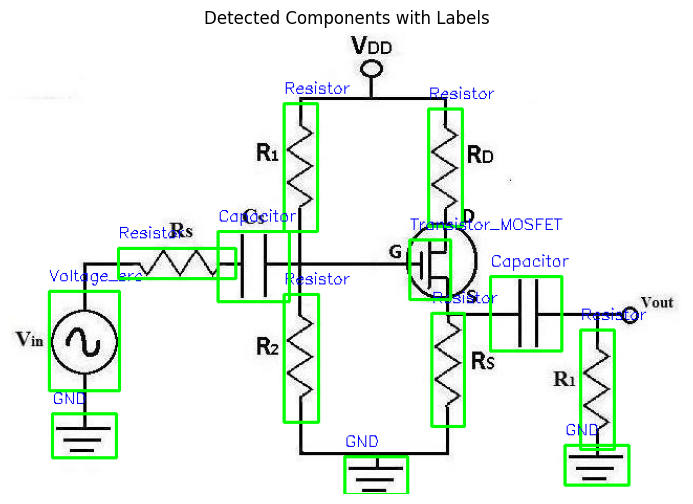

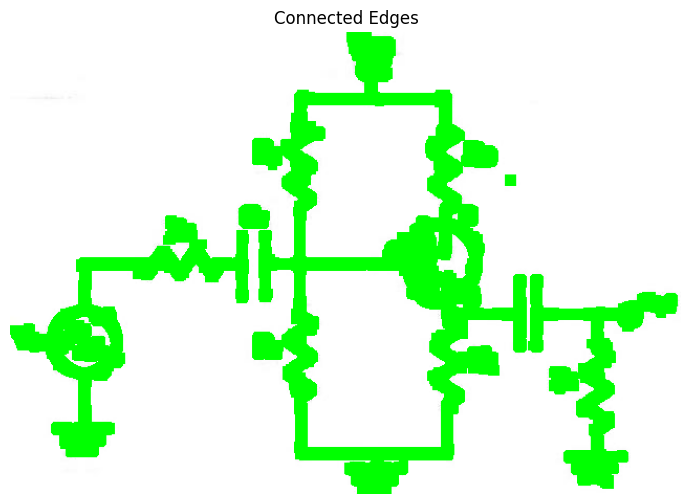

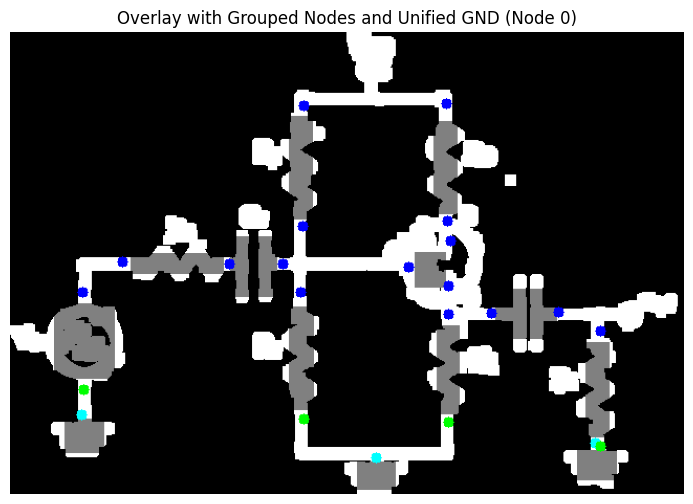


Number of unique nodes detected (excluding GND): 5
Saved annotated image: /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 2/Test outputs/GND_test/annotated.jpg
Saved node image: /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 2/Test outputs/GND_test/nodes.jpg
Processing image: simple_0003.jpg

image 1/1 /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Test images/simple_0003.jpg: 608x640 4 Resistors, 1 Transistor_BJT, 2 GNDs, 1436.8ms
Speed: 3.4ms preprocess, 1436.8ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


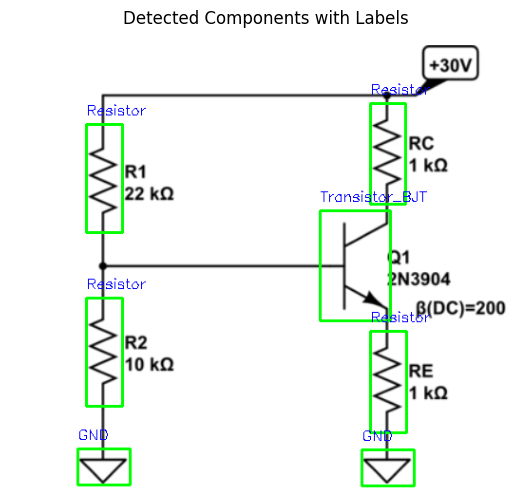

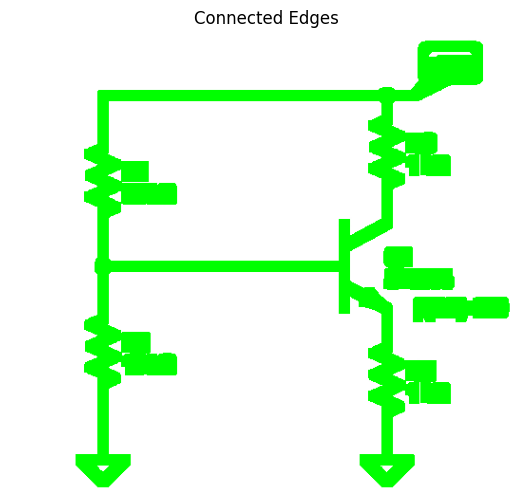

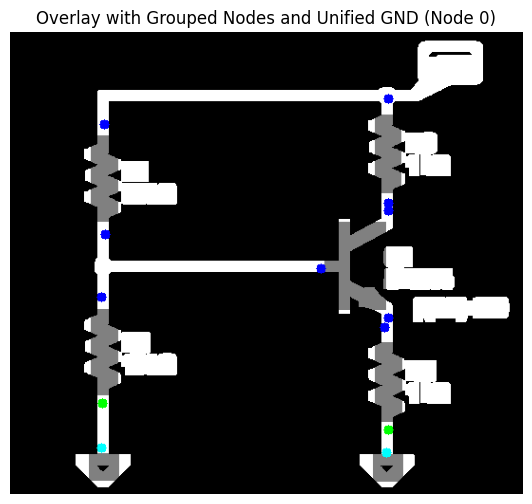


Number of unique nodes detected (excluding GND): 4
Saved annotated image: /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 2/Test outputs/simple_0003/annotated.jpg
Saved node image: /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 2/Test outputs/simple_0003/nodes.jpg
Processing image: simple_0002.jpg

image 1/1 /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Test images/simple_0002.jpg: 480x640 3 Resistors, 1 Voltage_src, 1144.6ms
Speed: 3.1ms preprocess, 1144.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


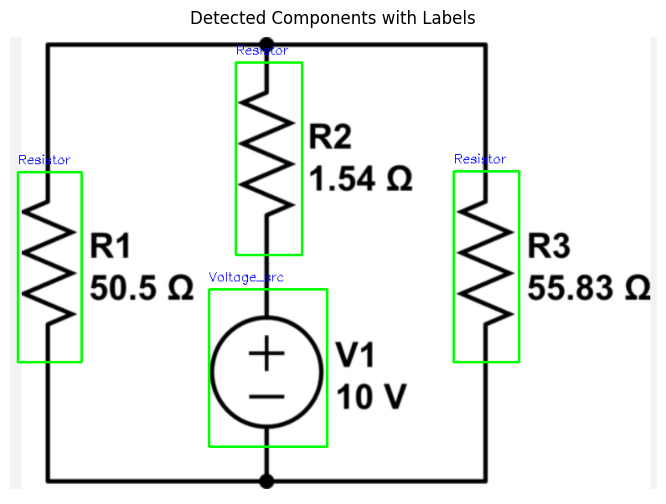

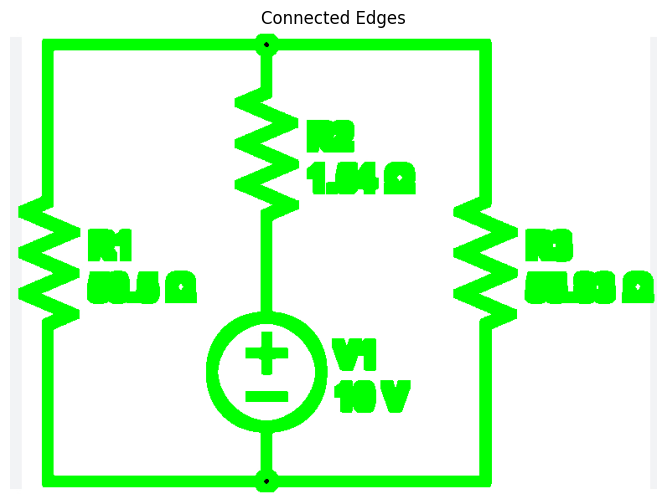

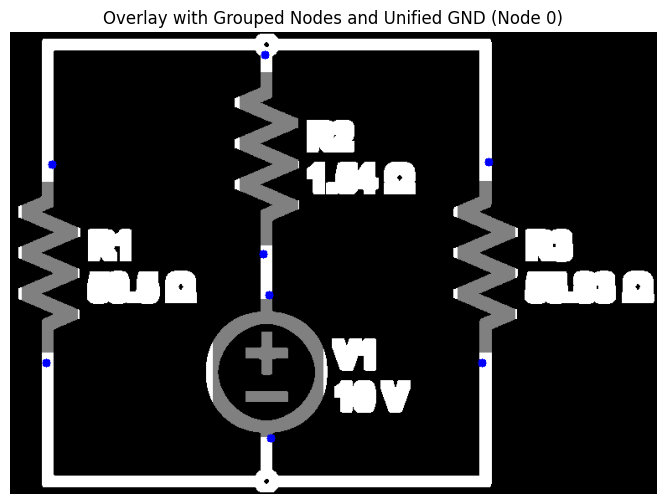


Number of unique nodes detected (excluding GND): 3
Saved annotated image: /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 2/Test outputs/simple_0002/annotated.jpg
Saved node image: /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 2/Test outputs/simple_0002/nodes.jpg
Processing image: simple_0001.jpg

image 1/1 /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Test images/simple_0001.jpg: 288x640 3 Resistors, 1 Voltage_src, 698.8ms
Speed: 3.7ms preprocess, 698.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


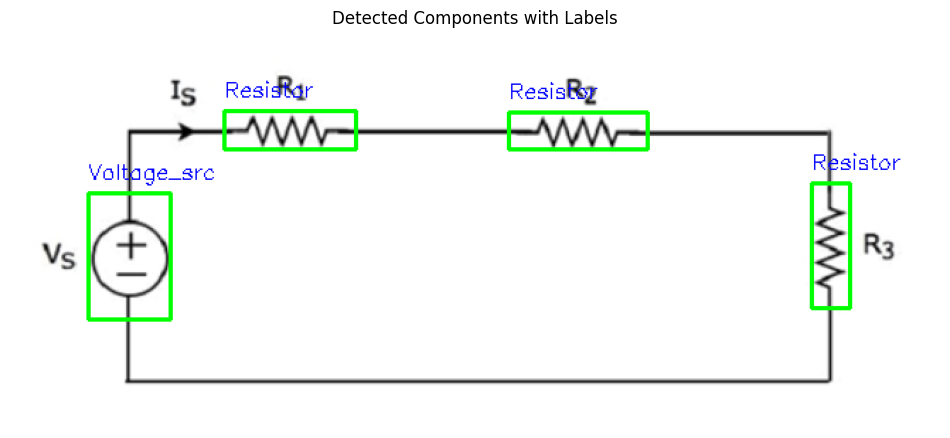

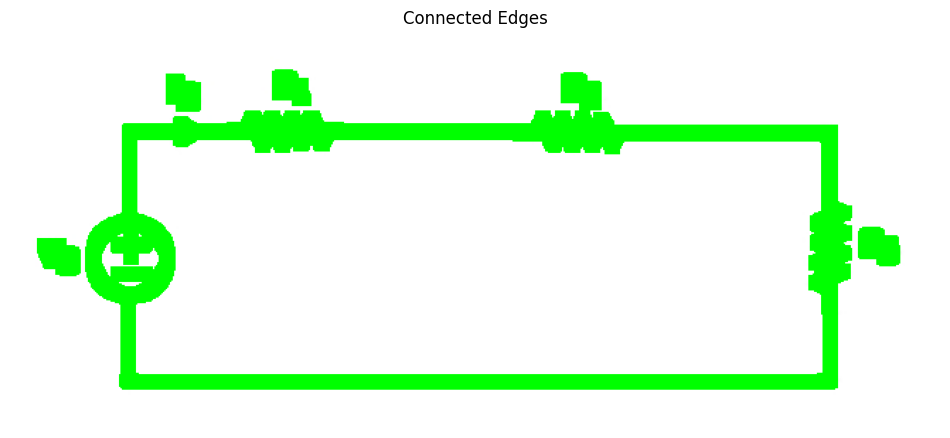

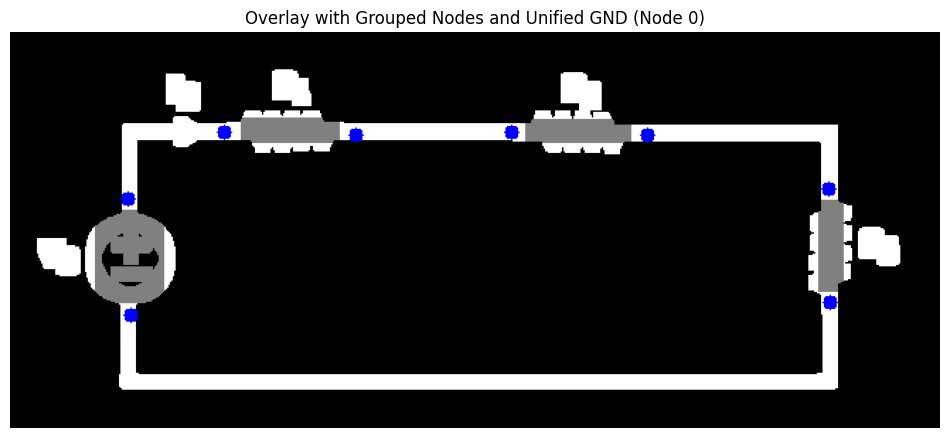


Number of unique nodes detected (excluding GND): 4
Saved annotated image: /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 2/Test outputs/simple_0001/annotated.jpg
Saved node image: /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 2/Test outputs/simple_0001/nodes.jpg


In [ ]:
import os
from ultralytics import YOLO
import cv2
import numpy as np
import json
from scipy.ndimage import label as connected_label
import matplotlib.pyplot as plt

#########################################
# Include Netlist Processing Functions
#########################################

# Include the full code of functions like draw_detected_components, visualize_everything_connected,
# mask_components, is_point_connected, and overlay_and_find_nodes here.

# Ensure to paste the netlist processing functions you provided in this section.

#########################################
# Process All Images
#########################################

def visualize_everything_connected(image_path, json_path):
    """
    Detect and visualize all edges in a schematic as one connected network.
    """
    with open(json_path, "r") as f:
        components = json.load(f)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(grayscale, 50, 150)
    kernel = np.ones((5, 5), np.uint8)
    connected_edges = cv2.dilate(edges, kernel, iterations=2)
    overlay = image.copy()
    overlay[connected_edges > 0] = [0, 255, 0]

    plt.figure(figsize=(12, 6))
    plt.title("Connected Edges")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return connected_edges, components


def mask_components(connected_edges, components):
    """
    Mask components by removing their bounding boxes from the connected edges.
    """
    masked_edges = connected_edges.copy()
    for component in components:
        bbox = component["bounding_box"]
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        shrink_x = 12 if width >= height else 5
        shrink_y = 12 if height >= width else 5
        shrink_x1 = max(x1 + shrink_x, 0)
        shrink_y1 = max(y1 + shrink_y, 0)
        shrink_x2 = max(x2 - shrink_x, 0)
        shrink_y2 = max(y2 - shrink_y, 0)
        cv2.rectangle(masked_edges, (shrink_x1, shrink_y1), (shrink_x2, shrink_y2), 0, -1)
    return masked_edges

def draw_detected_components(image_path, components):
    """
    Draw the detected components on the image and label them.
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    for component in components:
        label = component["label"]
        x1, y1, x2, y2 = component["bounding_box"]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    plt.figure(figsize=(12, 6))
    plt.title("Detected Components with Labels")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return image

def is_point_connected(masked_edges, px, py, kernel_size=3):
    """
    Check if a point is connected by examining a small neighborhood around it.
    Args:
        masked_edges (numpy.ndarray): Binary image with components masked.
        px (int): X-coordinate of the point.
        py (int): Y-coordinate of the point.
        kernel_size (int): Size of the neighborhood to check (default: 3x3).
    Returns:
        bool: True if the point is connected, False otherwise.
    """
    half_size = kernel_size // 2
    # Extract a small neighborhood around the point
    neighborhood = masked_edges[
        max(0, py - half_size): min(masked_edges.shape[0], py + half_size + 1),
        max(0, px - half_size): min(masked_edges.shape[1], px + half_size + 1)
    ]
    # Check if any pixel in the neighborhood is connected
    return np.any(neighborhood > 0)

def overlay_and_find_nodes(connected_edges, masked_edges, components, test_results_path, image_file):
    """
    Overlay the connected edges with masked components to find and group nodes.
    Ensure all GND components are unified as node 0, and propagate node 0 to components connected to GND.
    Save the results to a .txt file in the test_results_path with unique component labels (e.g., Resistor_1).
    Args:
        connected_edges (numpy.ndarray): Binary image of connected edges.
        masked_edges (numpy.ndarray): Binary image with components masked.
        components (list): List of component dictionaries with connection points.
        test_results_path (str): Path to save the results text file.
        image_file (str): Name of the image being processed.
    Returns:
        tuple: Image showing detected nodes and the number of unique nodes.
    """
    # Overlay images
    overlay = cv2.addWeighted(connected_edges, 0.5, masked_edges, 0.5, 0)

    # Create a copy to draw nodes
    node_image = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)

    # Perform connected component analysis
    labeled_edges, num_regions = connected_label(masked_edges)

    # Dictionary to map regions to nodes
    region_to_node = {}
    unique_nodes = set()
    current_node_id = 1  # Start from node 1, as node 0 is reserved for GND

    # Component count tracker for unique labels
    component_counts = {}

    # Helper function to generate unique labels
    def get_component_label(label):
        if label not in component_counts:
            component_counts[label] = 1
        else:
            component_counts[label] += 1
        return f"{label}_{component_counts[label]}"

    # Identify all regions connected to GND
    gnd_regions = set()
    for component in components:
        if component["label"].upper() == "GND":  # Check if the component is GND
            for point in component["connection_points"]:
                px, py = point
                if is_point_connected(masked_edges, px, py):
                    region = labeled_edges[py, px]
                    gnd_regions.add(region)
                    cv2.circle(node_image, (px, py), 5, (0, 255, 255), -1)  # Yellow for GND
                    region_to_node[region] = 0  # Assign node 0 to the GND region

    # Prepare text file path for results
    image_results_file = os.path.join(test_results_path, os.path.splitext(image_file)[0] + '.txt')

    # Open the results file for writing
    with open(image_results_file, 'w') as results_file:
        for component in components:
            # Skip GND components
            if component["label"].upper() == "GND":
                continue

            connected_nodes = []
            for point in component["connection_points"]:
                px, py = point
                if py >= labeled_edges.shape[0] or px >= labeled_edges.shape[1]:
                    continue  # Out of bounds

                if is_point_connected(masked_edges, px, py):
                    region = labeled_edges[py, px]

                    if region in gnd_regions:
                        connected_nodes.append(0)  # Assign node 0 for regions connected to GND
                        cv2.circle(node_image, (px, py), 5, (0, 255, 0), -1)  # Green for GND-connected nodes
                    elif region > 0:
                        if region not in region_to_node:
                            region_to_node[region] = current_node_id
                            current_node_id += 1
                        node_id = region_to_node[region]
                        unique_nodes.add(node_id)
                        connected_nodes.append(node_id)
                        cv2.circle(node_image, (px, py), 5, (0, 0, 255), -1)  # Red for connected nodes
                    else:
                        cv2.circle(node_image, (px, py), 5, (255, 0, 0), -1)  # Blue for unconnected points

            # Deduplicate nodes
            connected_nodes = list(set(connected_nodes))
            # Write component connection to file in the required format with unique labels
            unique_label = get_component_label(component["label"])
            results_file.write(f"{unique_label} {' '.join(map(str, connected_nodes))}\n")

    # Show the overlay with deduplicated nodes and GND highlights
    plt.figure(figsize=(12, 6))
    plt.title("Overlay with Grouped Nodes and Unified GND (Node 0)")
    plt.imshow(node_image)
    plt.axis('off')
    plt.show()

    # Print the total number of unique nodes
    print(f"\nNumber of unique nodes detected (excluding GND): {len(unique_nodes)}")

    return node_image, len(unique_nodes)

def process_all_images(test_images_folder, model_path, output_files_path, test_results_path):
    """
    Process all images in the folder using the YOLO model and netlist functions.

    Args:
        test_images_folder (str): Path to the folder containing images.
        model_path (str): Path to the YOLO model file.
        output_files_path (str): Path to the folder for saving results and visualizations.
        test_results_path (str): Path to the folder for saving netlist files.
    """
    os.makedirs(output_files_path, exist_ok=True)
    os.makedirs(test_results_path, exist_ok=True)

    # Load YOLO model
    model = YOLO(model_path)

    # Get all image files in the folder
    image_files = [f for f in os.listdir(test_images_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Process each image
    for image_file in image_files:
        image_path = os.path.join(test_images_folder, image_file)

        # Create a subfolder for each image in the output_files_path
        image_output_folder = os.path.join(output_files_path, os.path.splitext(image_file)[0])
        os.makedirs(image_output_folder, exist_ok=True)

        # Define paths for JSON and output images inside the subfolder
        json_path = os.path.join(image_output_folder, 'circuit_info.json')
        annotated_image_path = os.path.join(image_output_folder, 'annotated.jpg')
        node_image_path = os.path.join(image_output_folder, 'nodes.jpg')

        print(f"Processing image: {image_file}")

        # Run YOLO model and save circuit information
        results = model(image_path)[0]
        circuit_info = []

        for result in results:
            for cls, keypoints, bbox in zip(result.boxes.cls.cpu().numpy(),
                                             result.keypoints.xy.cpu().numpy(),
                                             result.boxes.xyxy.cpu().numpy()):
                class_idx = int(cls)
                object_name = results.names[class_idx]

                x_min, y_min, x_max, y_max = map(int, bbox)
                bounding_box = [x_min, y_min, x_max, y_max]

                connection_points = [
                    [int(point[0]), int(point[1])] for point in keypoints if not (point[0] == 0 and point[1] == 0)
                ]

                circuit_info.append({
                    "label": object_name,
                    "bounding_box": bounding_box,
                    "connection_points": connection_points
                })

        # Save JSON data
        with open(json_path, 'w') as json_file:
            json.dump(circuit_info, json_file, indent=4)

        # Apply netlist visualization and processing
        annotated_image = draw_detected_components(image_path, circuit_info)
        connected_edges, components = visualize_everything_connected(image_path, json_path)
        masked_edges = mask_components(connected_edges, components)
        # node_image, num_nodes = overlay_and_find_nodes(connected_edges, masked_edges, components)
        node_image, num_nodes = overlay_and_find_nodes(connected_edges, masked_edges, components, test_results_path, image_file)
        # Save or display the annotated image and node image
        cv2.imwrite(annotated_image_path, annotated_image)
        cv2.imwrite(node_image_path, node_image)

        print(f"Saved annotated image: {annotated_image_path}")
        print(f"Saved node image: {node_image_path}")

#########################################
# Execute for All Images in a Folder
#########################################

model_path = '/content/gdrive/My Drive/Netlist generator/Current trained model/pose/train/weights/last.pt'
main_path = '/content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/'
test_images_folder = main_path + 'Test images/'
output_files_path = main_path + 'Method 2/Test outputs for debugging/'
test_results_path = main_path + 'Method 2/Test results/'

process_all_images(test_images_folder, model_path, output_files_path, test_results_path)